In [ ]:
from inspect import getfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

import deepdrr
from deepdrr import geo, Volume, MobileCArm, Projector
from deepdrr.load_dicom import load_dicom
from diffdrr.drr import DRR
from diffdrr.metrics import NormalizedCrossCorrelation2d

In [ ]:
SDR = 400
P = 4.0

In [ ]:
# Load a DICOM and extract voxel information
example_ct_path = str(Path(getfile(DRR)).parent / "data/cxr") + "/"
volume, materials, spacing = load_dicom(example_ct_path)

# Make volume conventions same as DiffDR
preprocess = lambda x: np.rot90(x, -1)[:, ::-1]
volume = preprocess(volume)
for key, value in materials.items():
    materials[key] = preprocess(value)

# Use the center of the volume as the "world" coordinates. The origin is the (0, 0, 0) index of the volume in the world frame.
vol_center = (np.array(volume.shape) - 1) / 2 * spacing
origin = geo.point(-vol_center[0], -vol_center[1], -vol_center[2])

# Create the volume object with segmentation
patient = Volume.from_parameters(
    data=volume,
    materials=materials,
    origin=origin,
    spacing=spacing,
    anatomical_coordinate_system="LPS",
)
patient.orient_patient(head_first=True, supine=True)

Using downloaded and verified file: /home/vivekg/datasets/DeepDRR_DATA/model_segmentation.pth.tar


In [ ]:
# defines the C-Arm device, which is a convenience class for positioning the Camera.
# isocenter=volume.center_in_world
carm = MobileCArm(
    isocenter=patient.center_in_world,
    rotate_camera_left=False,
    source_to_detector_distance=SDR*2,
    source_to_isocenter_vertical_distance=SDR,
    pixel_size=P,
    sensor_height=256,
    sensor_width=256,
    min_alpha=-720, max_alpha=720, min_beta=-720, max_beta=720
)

def test_phantom_deepdrr(theta, phi, gamma):
    with Projector(
        volume=patient,
        carm=carm,
    ) as projector:
        carm.move_to(
            alpha=np.rad2deg(theta),
            beta=np.rad2deg(np.pi/2-phi),
            gamma=np.rad2deg(-gamma),
            degrees=True,
        )
        img = projector()  # The first run doesn't use updated parameters, for some reason?
        img = projector()[:, ::-1].copy()
    return img

In [ ]:
def test_phantom_diffdrr(theta, phi, gamma, sdr=SDR, p=P):
    bx, by, bz = (torch.tensor(volume.shape) - 1) * torch.tensor(spacing) / 2
    drr = DRR(volume, spacing, sdr=SDR, height=256, delx=P, convention="deepdrr")
    img = drr(torch.tensor([[theta, phi, gamma]]), torch.tensor([[bx, by, bz]]))
    img = img / img.max()
    return img

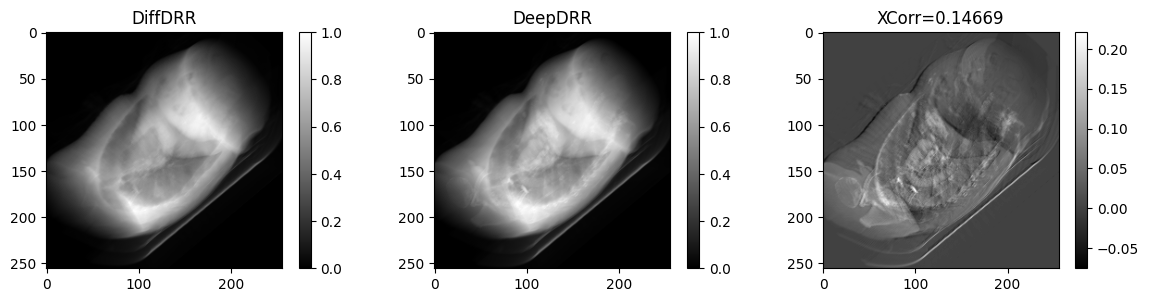

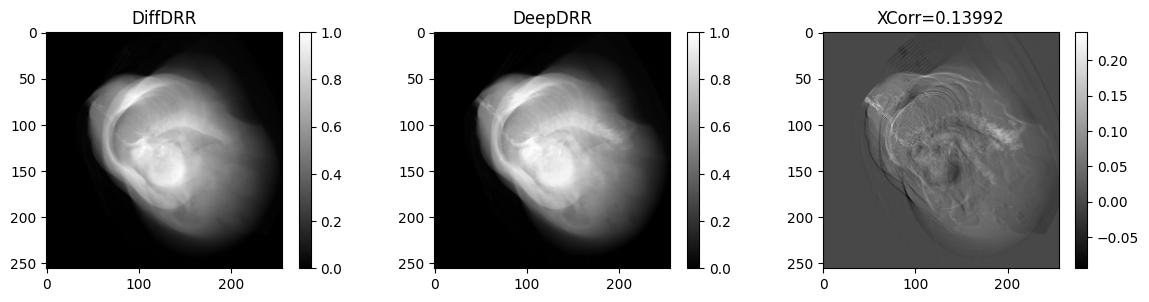

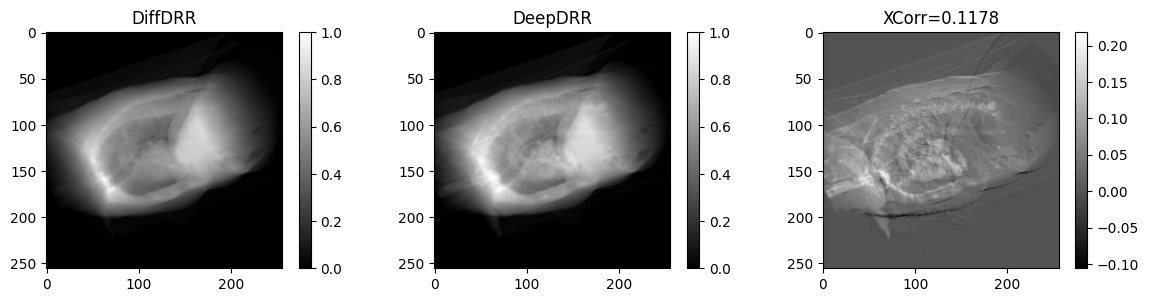

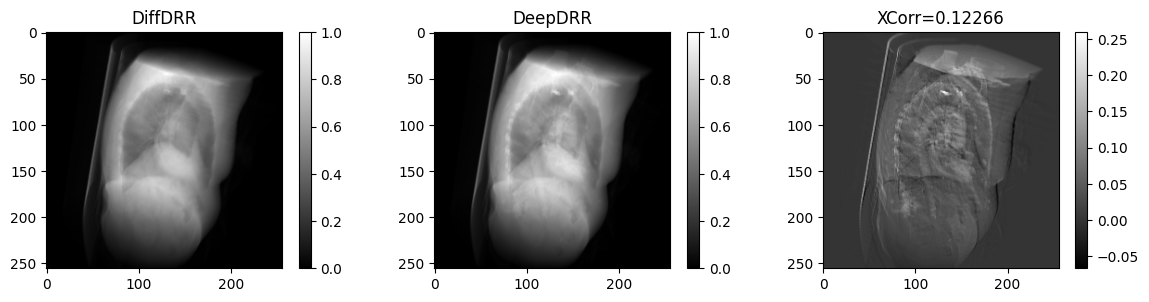

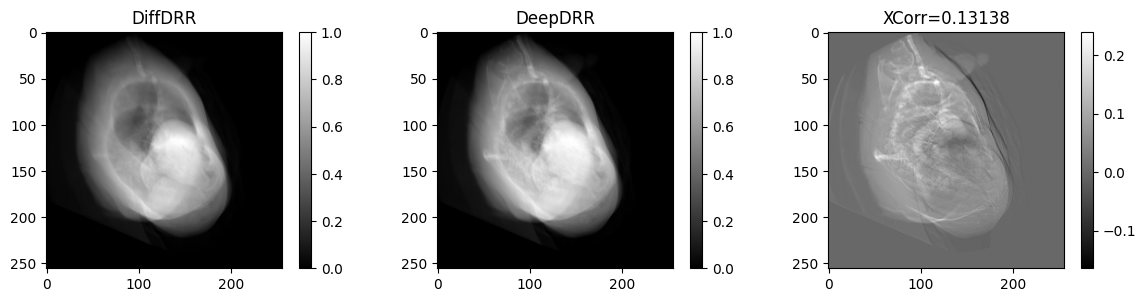

In [ ]:
for idx in range(5):
    theta = np.random.uniform(-torch.pi, torch.pi)
    phi = np.random.uniform(-torch.pi, torch.pi)
    gamma = np.random.uniform(-torch.pi, torch.pi)
    diff = test_phantom_diffdrr(theta, phi, gamma).squeeze().numpy()
    deep = test_phantom_deepdrr(theta, phi, gamma)
    metric = NormalizedCrossCorrelation2d()(
        torch.tensor(diff[np.newaxis, np.newaxis, ...]),
        torch.tensor(deep[np.newaxis, np.newaxis, ...])
    ).item()

    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.title("DiffDRR")
    plt.imshow(diff, cmap="gray")
    plt.colorbar()
    plt.subplot(132)
    plt.title("DeepDRR")
    plt.imshow(deep, cmap="gray")
    plt.colorbar()
    plt.subplot(133)
    plt.title(f"NCC = {metric:.5g}")
    plt.imshow(deep-diff, cmap="gray")
    plt.colorbar()
    plt.tight_layout()
    plt.show()